In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Lambda
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import matplotlib.image as mpimg

In [6]:
import os

In [7]:
def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

In [8]:
def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

In [9]:
mkdir('./fruits-360-small')

In [10]:
train_path_from = os.path.abspath('../Tensorflow-Bootcamp-master/03-Convolutional-Neural-Networks/fruits-360/Training')
valid_path_from = os.path.abspath('../Tensorflow-Bootcamp-master/03-Convolutional-Neural-Networks/fruits-360/Test')

In [11]:
train_path_to = os.path.abspath('./fruits-360-small/Training')
valid_path_to = os.path.abspath('./fruits-360-small/Validation')

In [12]:
mkdir(train_path_to)
mkdir(valid_path_to)

In [13]:
classes = [
  'Avocado',
  'Lemon',
  'Mango',
  'Kiwi',
  'Strawberry',
]

In [14]:
for c in classes:
    link(train_path_from + '/' + c, train_path_to + '/' + c)
    link(valid_path_from + '/' + c, valid_path_to + '/' + c)

In [15]:
train_dir = './fruits-360-small/Training'
valid_dir = './fruits-360-small/Validation'

In [16]:
from glob import glob

In [17]:
train_image_files = glob(train_dir + '/*/*.jp*g')
valid_image_files = glob(valid_dir + '/*/*.jp*g')

In [18]:
num_train = len(train_image_files)
num_valid = len(valid_image_files)

In [19]:
print(num_train, num_valid)

2367 793


In [20]:
num_class = len(classes)

In [21]:
num_class

5

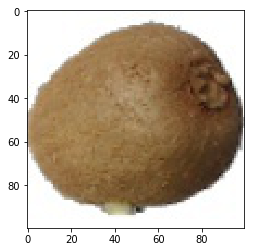

In [22]:
rand_image_name = np.random.choice(train_image_files)
rand_image = mpimg.imread(rand_image_name)
plt.imshow(rand_image)

In [23]:
vgg = VGG16(input_shape=(100,100,3), weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
x = Flatten()(vgg.output)

In [26]:
dense = Dense(units=512, activation='relu')(x)

In [27]:
drop = Dropout(rate=0.5)(dense)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
prediction = Dense(units=num_class, activation='softmax')(drop)

In [29]:
model = Model(inputs=vgg.input, outputs=prediction)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [32]:
gen = ImageDataGenerator(rotation_range=20,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.1,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True,
                        preprocessing_function=preprocess_input)

In [33]:
test_gen = gen.flow_from_directory(valid_dir, target_size=(100,100))
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 793 images belonging to 5 classes.
{'Avocado': 0, 'Kiwi': 1, 'Lemon': 2, 'Mango': 3, 'Strawberry': 4}


In [34]:
for x,y in test_gen:
    print(x.shape)
    print(y.shape)
    break

(32, 100, 100, 3)
(32, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -64.928665 max: 151.061


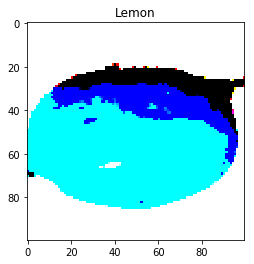

In [35]:
for x,y in test_gen:
    print('min:', x[0].min(), 'max:', x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    break

In [36]:
train_generator = gen.flow_from_directory(train_dir, target_size=(100,100))
test_generator = gen.flow_from_directory(valid_dir, target_size=(100,100))

Found 2367 images belonging to 5 classes.
Found 793 images belonging to 5 classes.


In [37]:
batch_size = 32

In [38]:
r = model.fit_generator(train_generator,
                        validation_data=test_generator,
                        epochs=3,
                        steps_per_epoch=num_train // batch_size,
                        validation_steps= num_valid // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
73/73 [==============================] - 157s 2s/step - loss: 4.6945 - acc: 0.6969 - val_loss: 3.4806 - val_acc: 0.7786
Epoch 2/3
73/73 [==============================] - 151s 2s/step - loss: 3.8926 - acc: 0.7537 - val_loss: 3.6861 - val_acc: 0.7648
Epoch 3/3
73/73 [==============================] - 154s 2s/step - loss: 3.5552 - acc: 0.7769 - val_loss: 3.0833 - val_acc: 0.8081


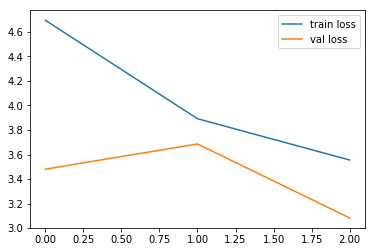

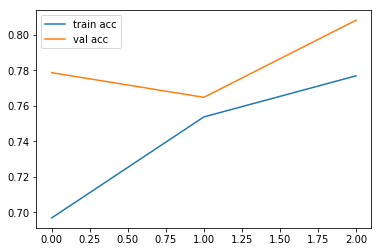

In [39]:
plt.figure()
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

plt.figure()
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()

In [ ]:
model.predict()